<a href="https://colab.research.google.com/github/Iman-hamdan/Iman-hamdan/blob/main/ImanHamdan_Assignment_3_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Complete LSTM Stock Price Prediction**

## **Assignment 3.1: Predicting Stock Prices Using RNN with LSTM**

## **1. Data Preparation**
**Objective:**

Choose a company listed in the S&P 500 with at least 5 years of historical data (2019–2024) and preprocess the data for use in an RNN model.
Steps:
Load the Data: Use the provided CSV file.
Feature Selection: Choose the Adj Close column for simplicity.
Normalization: Normalize the data using Min-Max Scaler.
Create Time-Series Windows: Prepare the data in a format suitable for RNN training.
Python


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import joblib
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import warnings
warnings.filterwarnings('ignore')

# Load the dataset
df = pd.read_csv('M3-AAPL.csv')
# Convert Date column to datetime and set as index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
print("Dataset loaded successfully!")
print(df.head())
print(f"Dataset shape: {df.shape}")
print(f"Date range: {df.index.min()} to {df.index.max()}")

Dataset loaded successfully!
                 Open       High        Low      Close  Adj Close     Volume
Date                                                                        
2019-05-28  44.730000  45.147499  44.477501  44.557499  43.002316  111792800
2019-05-29  44.105000  44.837502  44.000000  44.345001  42.797237  113924800
2019-05-30  44.487499  44.807499  44.167500  44.575001  43.019211   84873600
2019-05-31  44.057499  44.497501  43.747501  43.767502  42.239895  108174400
2019-06-03  43.900002  44.480000  42.567501  43.325001  41.812828  161584400
Dataset shape: (1259, 6)
Date range: 2019-05-28 00:00:00 to 2024-05-24 00:00:00


In [3]:
# Feature Selection and Normalization
from sklearn.preprocessing import MinMaxScaler

# Select the 'Adj Close' column
close = df[['Adj Close']].copy()

# Normalize the data
scaler = MinMaxScaler(feature_range=(0,1))
close_scaled = scaler.fit_transform(close)

# Save scaler for later inverse-transform
import joblib
joblib.dump(scaler, 'scaler.gz')

['scaler.gz']

In [4]:
# Create Time-Series Windows
import numpy as np

def make_dataset(series, look_back=60):
    X, y = [], []
    for i in range(look_back, len(series)):
        X.append(series[i-look_back:i, 0])
        y.append(series[i, 0])
    return np.array(X), np.array(y)

LOOK_BACK = 60
X, y = make_dataset(close_scaled, LOOK_BACK)
X = np.expand_dims(X, axis=-1)
TRAIN_SPLIT = 0.8
split = int(len(X)*TRAIN_SPLIT)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]
print("Train:", X_train.shape, y_train.shape)

Train: (959, 60, 1) (959,)


## 2. Model Development
Objective: Construct an RNN model using TensorFlow or PyTorch. Incorporate LSTM units to address the vanishing gradient problem and improve memory retention across time steps.

In [5]:
# Feature Selection and Normalization

close = df[['Adj Close']].copy()

# Normalize the data
scaler = MinMaxScaler(feature_range=(0,1))
close_scaled = scaler.fit_transform(close)

# Save scaler for later inverse-transform
joblib.dump(scaler, 'scaler.gz')
print("Data normalized and scaler saved!")

# Cell 3: Create Time-Series Windows
def make_dataset(series, look_back=60):
    """Create time-series windows for LSTM training"""
    X, y = [], []
    for i in range(look_back, len(series)):
        X.append(series[i-look_back:i, 0])
        y.append(series[i, 0])
    return np.array(X), np.array(y)

LOOK_BACK = 60
X, y = make_dataset(close_scaled, LOOK_BACK)
X = np.expand_dims(X, axis=-1)  # (samples, timesteps, features)

# Split data
TRAIN_SPLIT = 0.8
split = int(len(X) * TRAIN_SPLIT)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print(f"Training data shape: {X_train.shape}, {y_train.shape}")
print(f"Test data shape: {X_test.shape}, {y_test.shape}")

Data normalized and scaler saved!
Training data shape: (959, 60, 1), (959,)
Test data shape: (240, 60, 1), (240,)


## Training
Objective: Train the RNN model on the prepared dataset, optimizing the loss function and choosing an appropriate optimizer to enhance model performance.

In [7]:

# Cell 4: Build the LSTM Model
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(LOOK_BACK, 1)),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
print("Model compiled successfully!")
model.summary()

Model compiled successfully!


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 60, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,345 (114.63 KB)

 Trainable params: 29,345 (114.63 KB)

 Non-trainable params: 0 (0.00 B)

## Prediction and Evaluation
**Objective:**

Enable the model to forecast future stock prices, starting from a given initial stock price input. Ensure the RNN model efficiently learns from the selected stock price data and accurately forecasts future trends.

In [8]:
# Cell 7: Inverse Transform Predictions
pred_scaled = model.predict(X_test)
pred = scaler.inverse_transform(pred_scaled.reshape(-1,1))
y_true = scaler.inverse_transform(y_test.reshape(-1,1))

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step


Starting model training...
Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 0.1656 - val_loss: 0.0233
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0162 - val_loss: 0.0020
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0091 - val_loss: 0.0112
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0069 - val_loss: 0.0039
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0068 - val_loss: 0.0021
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0055 - val_loss: 0.0026
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0053 - val_loss: 0.0021
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0061 - val_loss: 0.0037
Epoch 9/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0054 - val_loss: 0.0040
Epoch 10/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0048 - val_loss: 0.0016
Epoch 11/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0042 - val_loss: 0.0016
Epoch 12/50
15/15 ━━━━━━━━━━━━━━━━━━

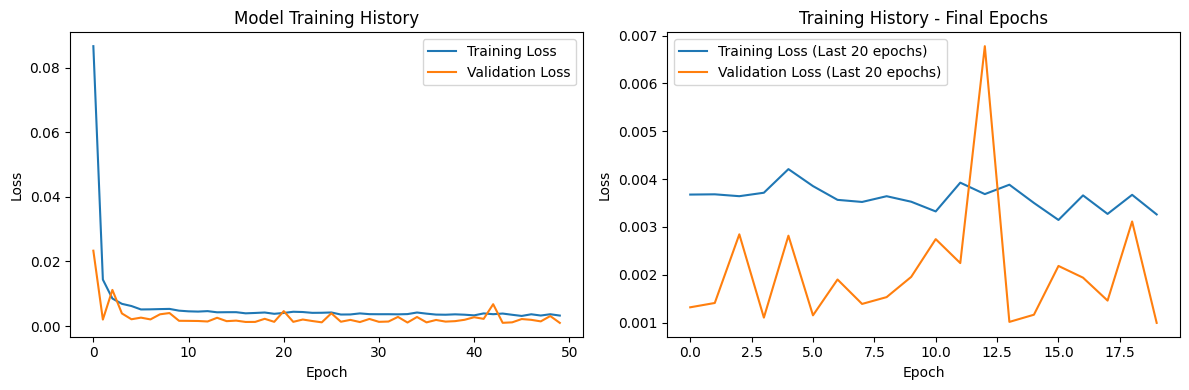

In [9]:
# Cell 5: Train the Model
EPOCHS = 50
BATCH_SIZE = 64

print("Starting model training...")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_test, y_test),
    verbose=1
)

# Cell 6: Plot Training History
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'][-20:], label='Training Loss (Last 20 epochs)')
plt.plot(history.history['val_loss'][-20:], label='Validation Loss (Last 20 epochs)')
plt.title('Training History - Final Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Future Forecasting
**Objective:**

Forecast future stock prices starting from the last known price.

Making predictions
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Model Performance Metrics:
MAE: $3.96
RMSE: $4.92
MAPE: 2.17%


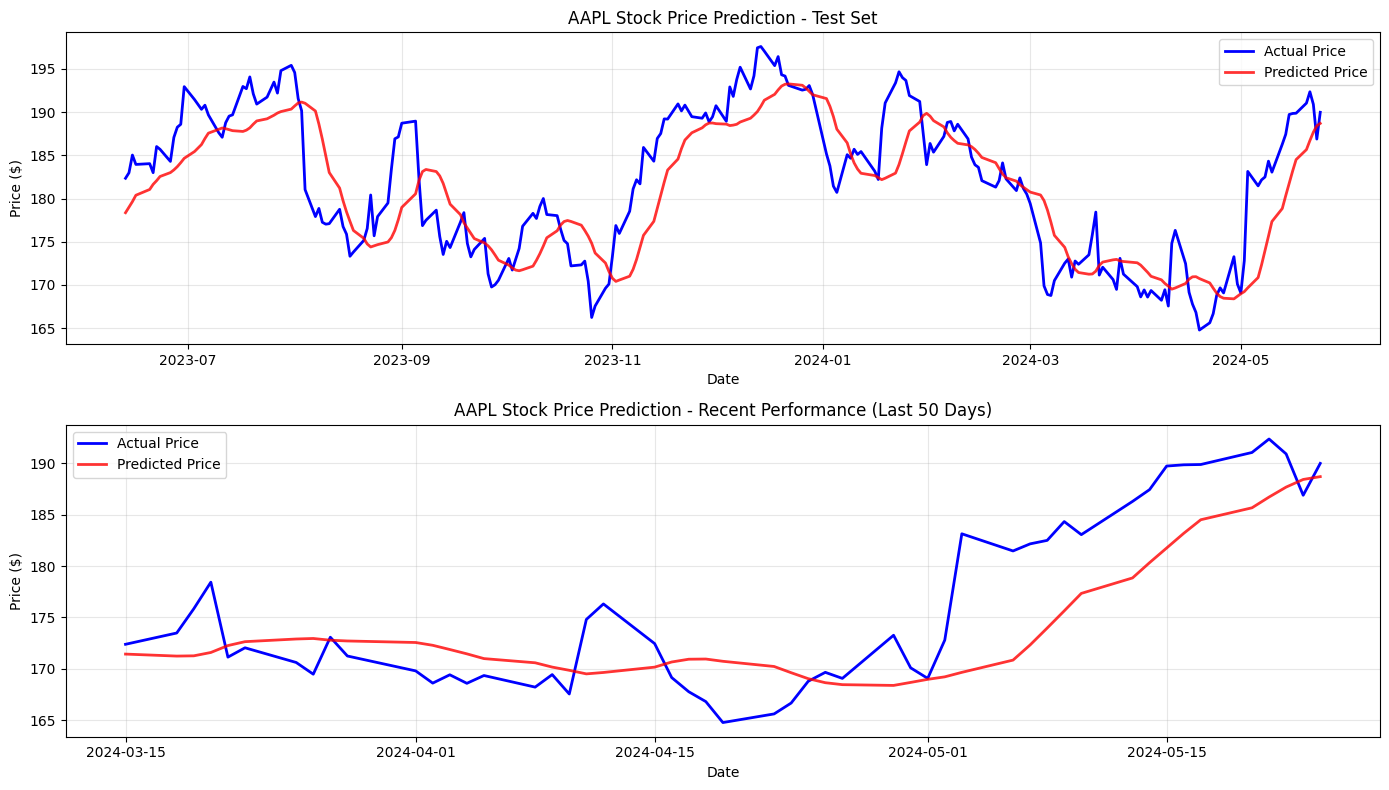

Generating future forecasts...
Future Price Forecasts (Next 30 Trading Days):
              Forecast
2024-05-27  188.857147
2024-05-28  188.828537
2024-05-29  188.673767
2024-05-30  188.429916
2024-05-31  188.125229
2024-06-03  187.780792
2024-06-04  187.412170
2024-06-05  187.030746
2024-06-06  186.644806
2024-06-07  186.260162


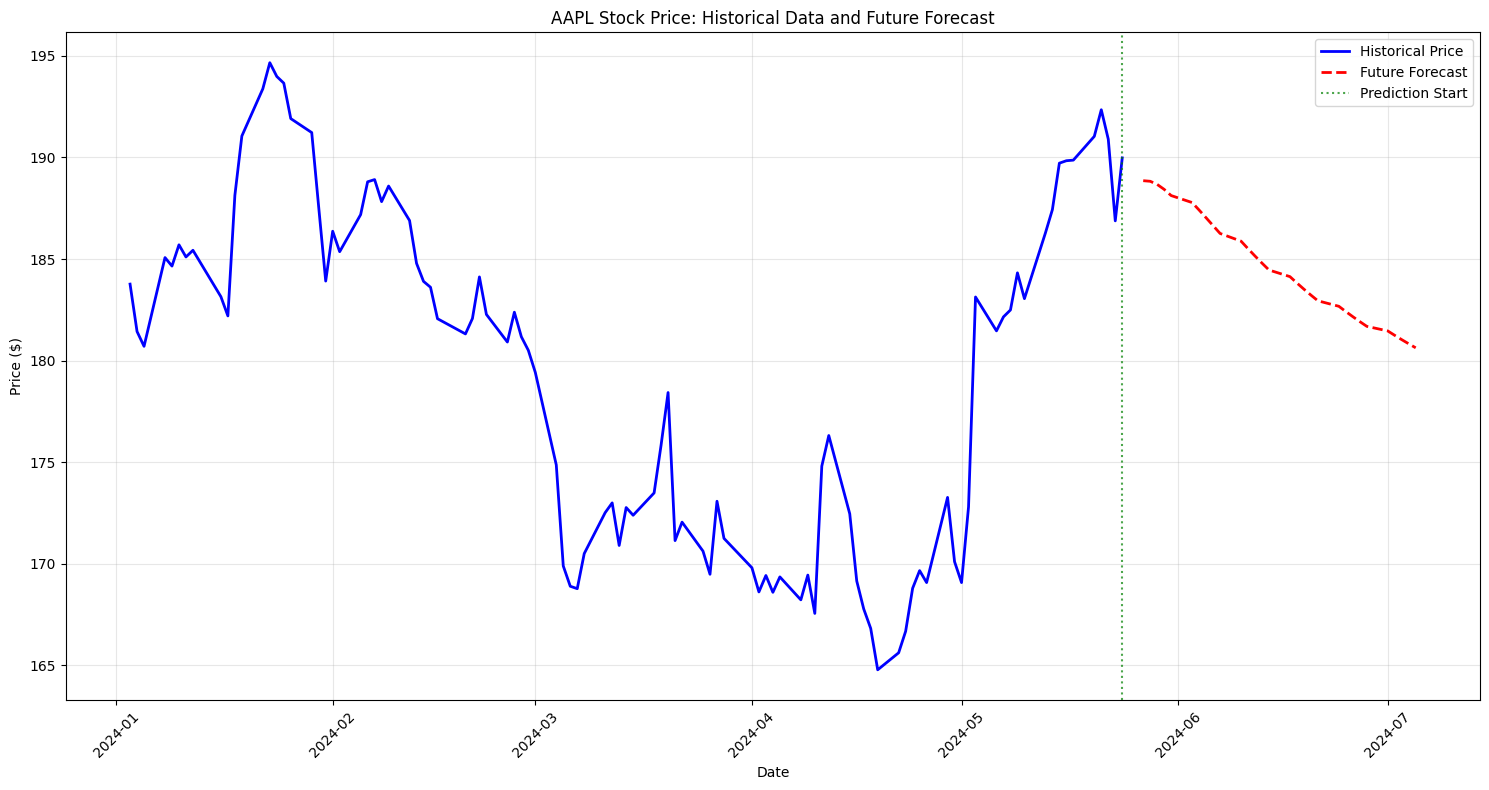


ASSIGNMENT SUMMARY
Company: Apple Inc. (AAPL)
Data Period: 2019-05-28 to 2024-05-24
Total Data Points: 1259
Training Samples: 959
Test Samples: 240
Lookback Window: 60 days
Training Epochs: 50

Model Performance:
  Mean Absolute Error: $3.96
  Root Mean Square Error: $4.92
  Mean Absolute Percentage Error: 2.17%

Future Forecast Summary:
  Current Price: $189.98
  30-Day Forecast Range: $180.63 - $188.86
  Predicted Direction: Downward
Future forecasts saved to 'AAPL_future_forecast.csv'


In [10]:

# Predictions and Evaluate
print("Making predictions")
pred_scaled = model.predict(X_test)
pred = scaler.inverse_transform(pred_scaled.reshape(-1, 1))
y_true = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate evaluation metrics
mae = mean_absolute_error(y_true, pred)
rmse = np.sqrt(mean_squared_error(y_true, pred))
mape = np.mean(np.abs((y_true - pred) / y_true)) * 100

print(f"Model Performance Metrics:")
print(f"MAE: ${mae:.2f}")
print(f"RMSE: ${rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

# Visualize Predictions
plt.figure(figsize=(14, 8))

# Get the corresponding dates for test predictions
test_dates = df.index[-len(y_true):]

plt.subplot(2, 1, 1)
plt.plot(test_dates, y_true, label='Actual Price', color='blue', linewidth=2)
plt.plot(test_dates, pred, label='Predicted Price', color='red', linewidth=2, alpha=0.8)
plt.title('AAPL Stock Price Prediction - Test Set')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True, alpha=0.3)

# Show recent performance (last 50 days)
plt.subplot(2, 1, 2)
recent_dates = test_dates[-50:]
recent_actual = y_true[-50:]
recent_pred = pred[-50:]

plt.plot(recent_dates, recent_actual, label='Actual Price', color='blue', linewidth=2)
plt.plot(recent_dates, recent_pred, label='Predicted Price', color='red', linewidth=2, alpha=0.8)
plt.title('AAPL Stock Price Prediction - Recent Performance (Last 50 Days)')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Future Forecasting (FIXED VERSION)
print("Generating future forecasts...")

# Get the last window for forecasting
last_window = close_scaled[-LOOK_BACK:]
forecast_horizon = 30  # next 30 trading days

# Generate predictions
future_predictions = []
current_window = last_window.reshape(1, LOOK_BACK, 1)

for i in range(forecast_horizon):
    # Predict next value
    next_pred = model.predict(current_window, verbose=0)[0, 0]
    future_predictions.append(next_pred)

    # Update window: remove first element, add prediction
    current_window = np.concatenate(
        (current_window[:, 1:, :], np.array([[[next_pred]]])),
        axis=1
    )

# Inverse transform predictions
future_prices = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Create future dates (business days only)
last_date = df.index[-1]
future_dates = pd.bdate_range(start=last_date + pd.Timedelta(days=1), periods=forecast_horizon)

# Create future dataframe
future_df = pd.DataFrame(
    future_prices,
    columns=['Forecast'],
    index=future_dates
)

print("Future Price Forecasts (Next 30 Trading Days):")
print(future_df.head(10))

# Visualize Future Forecasts
plt.figure(figsize=(15, 8))

# Historical data (last 100 days)
historical_data = df['Adj Close'][-100:]
historical_dates = df.index[-100:]

plt.plot(historical_dates, historical_data, label='Historical Price', color='blue', linewidth=2)
plt.plot(future_dates, future_prices, label='Future Forecast', color='red', linewidth=2, linestyle='--')

# Add vertical line at prediction start
plt.axvline(x=last_date, color='green', linestyle=':', alpha=0.7, label='Prediction Start')

plt.title('AAPL Stock Price: Historical Data and Future Forecast')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Summary Statistics
print("\n" + "="*50)
print("ASSIGNMENT SUMMARY")
print("="*50)
print(f"Company: Apple Inc. (AAPL)")
print(f"Data Period: {df.index.min().strftime('%Y-%m-%d')} to {df.index.max().strftime('%Y-%m-%d')}")
print(f"Total Data Points: {len(df)}")
print(f"Training Samples: {len(X_train)}")
print(f"Test Samples: {len(X_test)}")
print(f"Lookback Window: {LOOK_BACK} days")
print(f"Training Epochs: {EPOCHS}")
print("\nModel Performance:")
print(f"  Mean Absolute Error: ${mae:.2f}")
print(f"  Root Mean Square Error: ${rmse:.2f}")
print(f"  Mean Absolute Percentage Error: {mape:.2f}%")
print(f"\nFuture Forecast Summary:")
print(f"  Current Price: ${df['Adj Close'].iloc[-1]:.2f}")
print(f"  30-Day Forecast Range: ${future_prices.min():.2f} - ${future_prices.max():.2f}")
print(f"  Predicted Direction: {'Upward' if future_prices[-1] > df['Adj Close'].iloc[-1] else 'Downward'}")
print("="*50)

# Save results
future_df.to_csv('AAPL_future_forecast.csv')
print("Future forecasts saved to 'AAPL_future_forecast.csv'")

In [11]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# predicted stock prices
mae = mean_absolute_error(y_true, pred)
rmse = np.sqrt(mean_squared_error(y_true, pred))
mape = np.mean(np.abs((y_true - pred) / y_true)) * 100

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}%")


MAE: 3.9551023500325537
RMSE: 4.915848962138028
MAPE: 2.17199566919178%


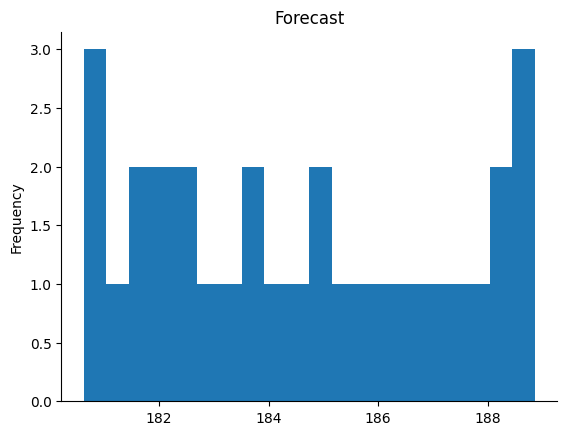

In [13]:
from matplotlib import pyplot as plt
future_df['Forecast'].plot(kind='hist', bins=20, title='Forecast')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [1]:
def colab2pdf():
  # @title Download Notebook in PDF Format{display-mode:'form'}
  !apt-get install -yqq --no-install-recommends librsvg2-bin>/dev/null;
  import contextlib,datetime,google,io,IPython,ipywidgets,json,locale,nbformat,os,pathlib,requests,urllib,warnings,werkzeug,yaml,re;locale.setlocale(locale.LC_ALL,'en_US.UTF-8');warnings.filterwarnings('ignore',category=nbformat.validator.MissingIDFieldWarning);
  %matplotlib inline
  def convert(b):
    try:
      s.value='🔄 Converting';b.disabled=True
      n=pathlib.Path(werkzeug.utils.secure_filename(urllib.parse.unquote(requests.get(f'http://{os.environ["COLAB_JUPYTER_IP"]}:{os.environ["KMP_TARGET_PORT"]}/api/sessions').json()[0]['name'])))
      p=pathlib.Path('/content/pdfs')/f'{datetime.datetime.utcnow().strftime("%Y%m%d_%H%M%S")}_{n.stem}';p.mkdir(parents=True,exist_ok=True);nb=nbformat.reads(json.dumps(google.colab._message.blocking_request('get_ipynb',timeout_sec=600)['ipynb']),as_version=4)
      u=[u for c in nb.cells if c.get('cell_type')=='markdown' for u in re.findall(r'!\[.*?\]\((https?://.*?)\)',c['source']) if requests.head(u,timeout=5).status_code!=200]
      if u:raise Exception(f"Bad Image URLs: {','.join(u)}")
      nb.cells=[cell for cell in nb.cells if '--Colab2PDF' not in cell.source]
      nb=nbformat.v4.new_notebook(cells=nb.cells or [nbformat.v4.new_code_cell('#')]);nbformat.validator.normalize(nb)
      nbformat.write(nb,(p/f'{n.stem}.ipynb').open('w',encoding='utf-8'))
      with (p/'config.yml').open('w', encoding='utf-8') as f: yaml.dump({'include-in-header':[{'text':r'\usepackage{fvextra}\DefineVerbatimEnvironment{Highlighting}{Verbatim}{breaksymbolleft={},showspaces=false,showtabs=false,breaklines,breakanywhere,commandchars=\\\{\}}'}],'include-before-body':[{'text':r'\DefineVerbatimEnvironment{verbatim}{Verbatim}{breaksymbolleft={},showspaces=false,showtabs=false,breaklines}'}]},f)
      !quarto render {p}/{n.stem}.ipynb --metadata-file={p}/config.yml --to pdf -M latex-auto-install -M margin-top=1in -M margin-bottom=1in -M margin-left=1in -M margin-right=1in --quiet
      google.colab.files.download(str(p/f'{n.stem}.pdf'));s.value=f'✅ Downloaded: {n.stem}.pdf'
    except Exception as e:s.value=f'❌ {str(e)}'
    finally:b.disabled=False
  if not pathlib.Path('/usr/local/bin/quarto').exists():
    !wget -q 'https://quarto.org/download/latest/quarto-linux-amd64.deb' && dpkg -i quarto-linux-amd64.deb>/dev/null && quarto install tinytex --update-path --quiet && rm quarto-linux-amd64.deb
  b=ipywidgets.widgets.Button(description='⬇️ Download');s=ipywidgets.widgets.Label();b.on_click(lambda b:convert(b));IPython.display.display(ipywidgets.widgets.HBox([b,s]))
colab2pdf() # | Colab2PDF v1.6 | https://github.com/drengskapur/colab2pdf | GPL-3.0-or-later |

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>